# 15-16: OLS (Abalone)

In [1]:
from ucimlrepo import fetch_ucirepo
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Caricamento dati + one-hot encoding

Il dataset ha una feature categoriale `Sex` (F/M/I). La trasformiamo in 3 colonne dummy (0/1).


In [2]:
abalone = fetch_ucirepo(id=1)
X: pd.DataFrame = abalone.data.features.copy()
y = abalone.data.targets.values.reshape(-1)  # 1D

# one-hot su Sex
X = pd.get_dummies(X, columns=["Sex"], drop_first=False)
for c in ["Sex_F", "Sex_M", "Sex_I"]:
    X[c] = X[c].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1,0


## OLS con intercetta + valutazione su test

In `statsmodels`, l'intercetta non è aggiunta automaticamente: la mettiamo con `add_constant`.
Poi stimiamo su train e valutiamo su test con RMSE/MAE/R².


In [3]:
X_train_c = sm.add_constant(X_train)
X_test_c  = sm.add_constant(X_test, has_constant="add")

ols = sm.OLS(y_train, X_train_c).fit()
print(ols.summary())

y_pred = ols.predict(X_test_c)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f} | MAE: {mae:.3f} | R^2: {r2:.3f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     425.5
Date:                Wed, 04 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:00:31   Log-Likelihood:                -7355.4
No. Observations:                3341   AIC:                         1.473e+04
Df Residuals:                    3331   BIC:                         1.479e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.6537      0.235     11.

### Come leggere `summary()` (in modo semplice)

- **R-squared / Adj. R-squared**: quanto il modello spiega sul *training* (utile, ma non basta).
- **F-statistic** e relativo **Prob (F-statistic)**: test globale “c’è almeno una feature utile?”.
- Tabella coefficienti:
  - **coef**: effetto stimato (a parità delle altre variabili).
  - **std err**: incertezza della stima.
  - **P>|t|**: se è piccola (es. < 0.05), il coefficiente è “diverso da 0” nel modello.
  - **[0.025, 0.975]**: intervallo di confidenza al 95% del coefficiente (se include 0, effetto poco certo).

In pratica: guarda sempre anche le metriche su **test** (RMSE/MAE/R²) e un controllo dei residui.


## Formula interface (più leggibile)

Con `smf.ols("y ~ x1 + x2 + ...", data=df)` i nomi restano chiari e la costante è inclusa di default.
Qui usiamo le colonne già preprocessate.


In [4]:
df_all = X.copy()
df_all["Rings"] = y

df_train = df_all.loc[X_train.index].copy()
df_test  = df_all.loc[X_test.index].copy()

formula = "Rings ~ " + " + ".join([c for c in df_train.columns if c != "Rings"])

ols_f = smf.ols(formula, data=df_train).fit()
print(ols_f.summary())

y_pred_f = ols_f.predict(df_test)
rmse_f = np.sqrt(mean_squared_error(df_test["Rings"], y_pred_f))
print(f"Test RMSE (formula): {rmse_f:.3f}")

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     425.5
Date:                Wed, 04 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:00:31   Log-Likelihood:                -7355.4
No. Observations:                3341   AIC:                         1.473e+04
Df Residuals:                    3331   BIC:                         1.479e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.6537      0.235     11.

## Intervalli di confidenza dei coefficienti

Utile per vedere quali coefficienti sono stimati con più precisione.


In [5]:
ci = ols.conf_int(alpha=0.05)
ci.columns = ["CI_low", "CI_high"]
coefs = ols.params.rename("coef")

coef_table = pd.concat([coefs, ci], axis=1).sort_values("coef", ascending=False)
coef_table.head(12)

,coef,CI_low,CI_high
Diameter,11.123391,6.129592,16.117190
Height,10.445325,7.278322,13.612329
Whole_weight,8.932176,7.239409,10.624942
Shell_weight,8.792378,6.228441,11.356315
const,2.653678,2.193204,3.114152
Sex_M,1.193068,0.999236,1.386901
Sex_F,1.089792,0.878976,1.300608
Sex_I,0.370818,0.195211,0.546425
Length,-0.201554,-4.280565,3.877458
Viscera_weight,-9.558916,-12.440667,-6.677166


## Predizione + intervalli

- `get_prediction(...).summary_frame()` produce anche intervalli.
- `mean_ci_*`: intervallo di confidenza della **media** E[Y|X].
- `obs_ci_*`: intervallo di **predizione** per una nuova osservazione (più largo).


In [6]:
pred = ols.get_prediction(X_test_c.iloc[:5])
pred.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
866,11.761361,0.123218,11.519770,12.002953,7.459743,16.062979
1483,10.241926,0.095967,10.053766,10.430087,5.942978,14.540875
599,14.001036,0.119701,13.766340,14.235731,9.699799,18.302272
1702,11.995093,0.079694,11.838839,12.151347,7.697423,16.292763
670,11.161415,0.094532,10.976069,11.346761,6.862589,15.460241


## Residui

- Residui vs fitted: se vedi pattern → possibile non linearità / varianza non costante.
- Q-Q plot: se molto lontano dalla diagonale → residui non “gaussiani” (non sempre un disastro, ma è un segnale).


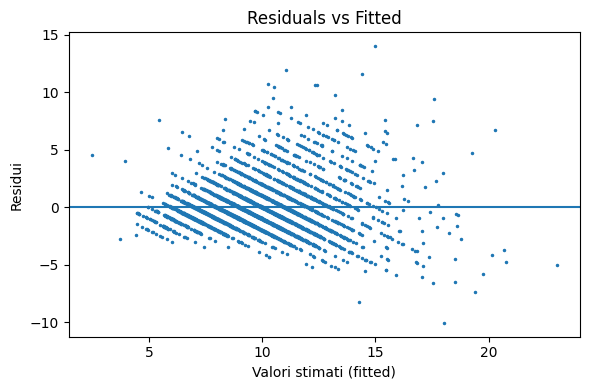

<Figure size 600x400 with 0 Axes>

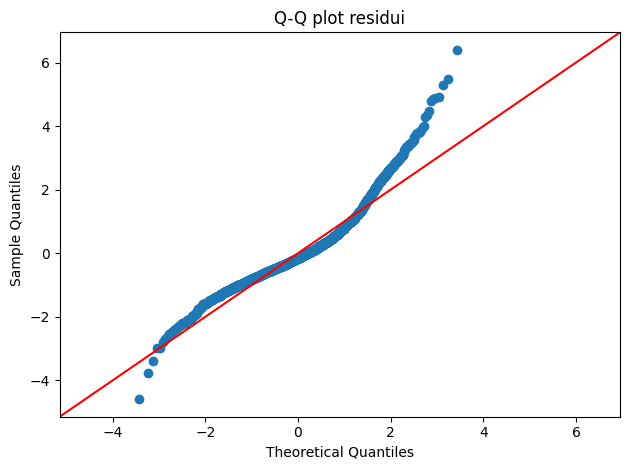

In [7]:
fitted = ols.fittedvalues
resid  = ols.resid

plt.figure(figsize=(6,4))
plt.plot(fitted, resid, ".", ms=3)
plt.axhline(0)
plt.xlabel("Valori stimati (fitted)")
plt.ylabel("Residui")
plt.title("Residuals vs Fitted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sm.qqplot(resid, line="45", fit=True)
plt.title("Q-Q plot residui")
plt.tight_layout()
plt.show()